In [1]:
import numpy as np
import math
from PIL import Image
 
def EuclideanDistance(point1,point2):
    # finding sum of squares 
    sum_sq = np.sum(np.square(point1 - point2))
    # Doing squareroot and 
    # printing Euclidean distance 
    return np.sqrt(sum_sq)

    
def alignment_procedure(img, left_eye, right_eye):
#this function aligns given face in img based on left and right eye coordinates
 
    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye

    #-----------------------
    #find rotation direction

    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 #rotate same direction to clock
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 #rotate inverse direction of clock

    #-----------------------
    #find length of triangle edges

    a = EuclideanDistance(np.array(left_eye), np.array(point_3rd))
    b = EuclideanDistance(np.array(right_eye), np.array(point_3rd))
    c = EuclideanDistance(np.array(right_eye), np.array(left_eye))

    #-----------------------

    #apply cosine rule

    if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation

        cos_a = (b*b + c*c - a*a)/(2*b*c)
        angle = np.arccos(cos_a) #angle in radian
        angle = (angle * 180) / math.pi #radian to degree

        #-----------------------
        #rotate base image

        if direction == -1:
            angle = 90 - angle

        img = Image.fromarray(img)
        img = np.array(img.rotate(direction * angle))

    #-----------------------

    return img #return img anyway
    

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 24 11:19:24 2020

@author: pchak
"""
import cv2
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
import pandas
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from numba import jit, cuda 
# import openpyxl module 
from openpyxl import Workbook,load_workbook
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'


output_location='D:\\SGE_Project2\\' #Output location path

def facealing(img):
    return img

def headpose(img):
    return img

excelfilename='Sample2_Large.xlsx'        #Excel file name
wb = Workbook() 
sheet = wb.active 
sheet['A1']="Frame number"  #total columns= 12
sheet['B1']="Detected_faces"
sheet['C1']="predicted_faces"
sheet['D1']="Sleepy_E0"
sheet['E1']="Boredome_E1"
sheet['F1']="Yawn_E2"
sheet['G1']="Frustrate_E3"
sheet['H1']="Confuse_E4"
sheet['I1']="Engage_E5"
sheet['J1']="Acc_EL1(E0+E1)"
sheet['K1']="Acc_EL2(E2+E3+E4)"
sheet['L1']="Acc_EL3(E5)" 
wb.save(output_location+excelfilename)
excel_path=output_location+excelfilename   


#save student emotion label data into excel
def writedata(lst1,lst2,lst3,lst4,lst5):
    temp_list=[0]*3
    temp_list[0]=lst1
    temp_list[1]=lst2
    temp_list[2]=lst3
    temp_list.extend(lst4)
    temp_list.extend(lst5)
    # To open the workbook  
    # workbook object is created 
    wb_obj = load_workbook(excel_path) 
    sheet=wb_obj.active
    sheet.append(temp_list)
    wb_obj.save(excel_path)

def graphfile(Fno,ELId):
    tempdata=[0]*2
    #framercounter=0
    #framercounter+=Fno
    tempdata[0]=Fno
    tempdata[1]=ELId
    with open(output_location+'eng_out_Sample2_Large.csv','a') as appendobj:
        append=csv.writer(appendobj,delimiter=",", lineterminator='\n')
        append.writerow(tempdata)
        appendobj.close()
    
    
#Load model for face Detection
print("Loding Face detector model......")
detector = MTCNN()
print("Face detector model is loded.")

#Load model for Emotion Detection
print("Loding Face emotion recognition model......")
model = load_model('G:\\00My papers publication stuff\\L1 Paper 1 stuff\\model10.h5')
print("Face emotion recognition model is loded.")

#Read input video stream
#cap=cv2.VideoCapture(0)
cap=cv2.VideoCapture('D:\\SGE_Project1\\avc_SAMPLEVERTICALNEW_S1.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


# Get frame rate of video stream
seconds = 0.5 # two frames per second get processed 
fps=cap.get(cv2.CAP_PROP_FPS) # Gets the frames per second
print("Frame rate",fps)
multiplier = fps * seconds

# Required data variables declaration
datalist=list()
frame_emotions=list() # list data structure for storing emotion lables of every frame
accumulator=[0]*6 # emotion accumulator.
EL_counter=[0]*3 #Engagement level counter.
GEL_counter=[0]*3 #Each video segment group engagemtn level index. 
FGEL_counter=[0]*3 # list to maintain overall class group engagement level.

#output video saving file into local disk
fourcc=cv2.VideoWriter_fourcc(*'MJPG')
op = cv2.VideoWriter(output_location+'test_Sample2_Large1.avi',fourcc,5,(width,height)) # 5fps in video #output video filename

FC=0
try:
    while(cap.isOpened()):
        frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
        ret, img_frame = cap.read()
        #frameId=frameId1.copy()
        if ret:
            if frameId % multiplier == 0:
                FC+=1
                #print("Frame Number:",frameId)
                temp_img=img_frame.copy()
                #print frame number on frame
                frame_ID="FrameNo:"+str(frameId)

                #frame_count="Frame_count"+str(FC)
                cv2.putText(temp_img, frame_ID, ((10), (50)), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,255), 2)

                #cv2.putText(temp_img, frame_count, ((10), (60)), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2,cv2.LINE_AA)

                #convert image from BGR2RGB which MTCNN works well
                img_frame = cv2.cvtColor(img_frame, cv2.COLOR_BGR2RGB)

                # Detection of faces using MTCNN face detection pre-trained model
                faces = detector.detect_faces(img_frame)
                #print("Detected faces:",len(faces))
                detected_faces=len(faces)
                predicted_faces=0

                #processing each face from the detected faces
                for face in faces:
                    # get face confidence
                    confidence_score=face['confidence']
                    #print(confidence_score)
                    if confidence_score <= 0.95: # to reduce false prediction occurence
                        xf, yf, wf, hf = face['box']
                        cv2.rectangle(temp_img,(xf-5,yf-5),(xf+wf+5,yf+hf+5),(0,0,255),2)
                        cv2.putText(temp_img, "Non_candidate_face", (int(xf), int(yf)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                        continue
                    x, y, w, h = face['box']
                    keypoints = face["keypoints"]
                    left_eye = keypoints["left_eye"]
                    right_eye = keypoints["right_eye"]
                    # create the shape
                    cv2.rectangle(temp_img,(x-5,y-5),(x+w+5,y+h+5),(0,255,255),2)
                
                    #cropping region of interest i.e. face area from  image
                    img_roi=img_frame[y:y+h,x:x+w]
                                              
                    #pre-processing
                    #1. head pose
                    pre_face1=headpose(img_roi)
                
                    #2. face alignment
                    pre_face2=alignment_procedure(pre_face1,left_eye,right_eye)
                
                    #3. face resize
                    resize_img=cv2.resize(pre_face2,(48,48))
                                              
                    #convert into model specific structure to predict emotion label.
                    img_pixels = image.img_to_array(resize_img)
                    img_pixels = np.expand_dims(img_pixels, axis = 0)
                    img_pixels /= 255
                                

                    #Emotion Prediction, it gives probabilities for each emotion to the given input face  
                    predictions = model.predict(img_pixels)

                    #count the no. of faces emotion predicted 
                    predicted_faces+=1

                    #find the index of predicted maximum probability emotion class 
                    max_index = np.argmax(predictions)
                    accumulator[max_index]+=1

                    emotions_ID = ('Sleepy', 'Boredome', 'Yawning', 'Frustrated','Confuse', 'Engage')
                    emotions = ('0','1','2','3','4','5')
                    predicted_emotion = emotions[max_index]
                    frame_emotions.extend(predicted_emotion) # write this and frame ID into excel file
                    cv2.putText(temp_img, emotions_ID[max_index], (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                #display image
                cv2.imshow("image",temp_img)
                #save frames to create video file 
                op.write(temp_img)
                #cv2.waitKey(0)
                #print(accumulator)
                # EL_ counters, save in excel sheet
                EL_counter[0]=EL_counter[0]+(accumulator[0]+accumulator[1])
                EL_counter[1]=EL_counter[1]+(accumulator[2]+accumulator[3]+accumulator[4])
                EL_counter[2]=EL_counter[2]+accumulator[5]

                #save data into excel file
                writedata(frameId,detected_faces,predicted_faces,accumulator,EL_counter)

                #print(EL_counter)
                accumulator[:]=[0]*6 #Reset accumulator to zero

                #if count(FC) % 20 == 0: #video segment length is every 10 seconds, 2 frames per second
            if FC == 20:
                GEL_index=np.argmax(EL_counter)
                #send data to write into csv file to get plot in line graph
                graphfile(frameId,GEL_index)
                #print("video segment group engagement index",GEL_index)
                FC=0
                EL_counter[:]=[0]*3 #reset the Egagement level counters
                GEL_counter[GEL_index]+=1 #keep track of video segments engagement index        
            #else:
             #   continue

            if cv2.waitKey(1) & 0xff == ord("q"):
                #op.write(temp_img)
                #writedata(frameId,detected_faces,predicted_faces,accumulator,EL_counter)
                raise #Exception("input video stream interrupted...!!!!")
                break
        else:
            break
    cap.release()
    #modified 26.12.2020, 5:30pm
    op.release()
    
except:
    print("Quit (Q) key is pressed and process was interrupted...!")
    print("---------------------------------------------------------")
    
finally:
    op.write(temp_img)
    writedata(frameId,detected_faces,predicted_faces,accumulator,EL_counter)
    graphfile(frameId,GEL_index)
    print("Video segments group engagement level counter:",GEL_counter)
    FGEF=np.argmax(GEL_counter)
    if FGEF == 0:
        print("Overall class engagement level is low:",FGEF)
    elif FGEF == 1:
        print("Overall class engagement level is Medium:",FGEF)
    else:
        print("Overall class engagement level is High:",FGEF)
    cv2.destroyAllWindows()

Using TensorFlow backend.


Loding Face detector model......
Face detector model is loded.
Loding Face emotion recognition model......
Face emotion recognition model is loded.
Frame rate 30.0
Video segments group engagement level counter: [4, 0, 2]
Overall class engagement level is low: 0


<IPython.core.display.Javascript object>


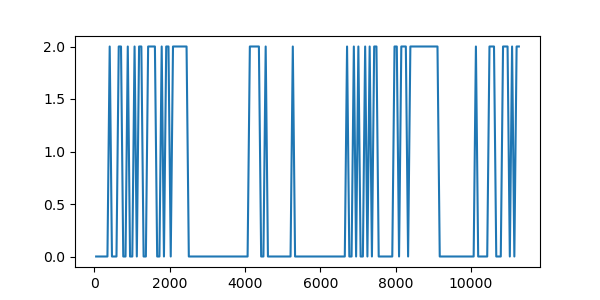

In [1]:
#final code for Graph 27.12.2020 1:20pm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from matplotlib import style
import numpy as np
from pylab import rcParams

%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

#%matplotlib inline
#rcParams['figure.figsize']=8,4

fig = plt.figure(figsize = (6,3))
ax1 = fig.add_subplot(1,1,1)


def animate(i):
    pullData = open("D:\\SGE_Project1\\VTU_Sample3.csv","r").read()
    dataArray = pullData.split('\n')
    xar = []
    yar = []
    for eachLine in dataArray:
        if len(eachLine)>1:
            x,y = eachLine.split(',')
            xar.append(int(x))
            yar.append(int(y))
    ax1.clear()
    ax1.plot(xar,yar)
    
    
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()